## Libraries and packages

In [1]:
from Bio import Entrez
import pandas as pd
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
# nltk.download()
from gensim.models import word2vec
from sklearn.manifold import TSNE

email = 'Your Email'

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


____________________________________________________________________________________

## Functions

In [2]:
def get_PMID_list(search_term):
    '''Returns a list of PMIDs from articles related to the search term'''
    Entrez.email = email
    handle = Entrez.esearch(db="pubmed", term=search_term, retmax=100000)
    record = Entrez.read(handle)
    return list(record["IdList"])

In [3]:
def get_articles_info(PMID_list):
    '''Fetches the articles and scrapes the information needed'''
    list_articles_info = []
    list_error = []

    # I was getting a XML parser error on some IDs, so I had to fetch them one by one instead of passing the whole
    # PMID list as the id parameter of the efetch method. 
    
    for ID in PMID_list:
        Entrez.email = email
        record = 'test'
        try:
            handle = Entrez.efetch(db="pubmed", id=ID, rettype="medline", retmode="xml")
            record = Entrez.read(handle)
            try:
                list_articles_info.append(
                    {'Id': record['PubmedArticle'][0]['MedlineCitation']['PMID'][:8], 
                    'Title': record['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleTitle'],
                    'Year': record['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleDate'][0]['Year'], 
                    'Abstract': record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText'][0]
                    })
                
            # Most IndexError were raised because of the 'Year' path, this is the alternative
            except IndexError:
                list_articles_info.append(
                    {'Id': record['PubmedArticle'][0]['MedlineCitation']['PMID'][:8], 
                    'Title': record['PubmedArticle'][0]['MedlineCitation']['Article']['ArticleTitle'],
                    'Year': record['PubmedArticle'][0]['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']['Year'], 
                    'Abstract': record['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText'][0]
                    })                
        except:
            # Records all IDs that were not fetched
            list_error.append(ID)
            pass
    
    list_to_file(list_error, 'listError')
    df_autism_articles = pd.DataFrame(list_articles_info)
    df_autism_articles.to_csv('AutismArticlesRaw.csv', encoding='utf-8', index=False)

In [4]:
def list_to_file(python_list, file_name):
    '''Saves a list to a .txt file at local folder'''
    file = open("{}.txt".format(file_name), "w")
    for element in python_list:
        file.write(element)
        if(element != python_list[-1]): # ensure that it doesn't print a blank line at the end of the file
            file.write("\n")
    file.close()

In [5]:
def file_to_list(file_name):
    '''Reads a .txt file into a list'''
    line_list = []
    file = open("{}.txt".format(file_name), "r")
    for line in file:
        line_list.append(line.rstrip('\n'))
    file.close()
    return line_list

_________________________________________________________________________________________

## Code

### First analysis

#### Getting the PMIDs

In [ ]:
autism_PMID_list = get_PMID_list('autism') # Search and returns a PMID list of articles matching 'autism' search term

In [159]:
print('A total of {} articles were found.'.format(len(autism_PMID_list)))

A total of 44927 articles were found.


In [ ]:
list_to_file(autism_PMID_list, 'autismPMIDList_2') # Saves the PMID list into a local .txt file to avoid repeting the web search

In [158]:
# autism_PMID_list = file_to_list('autismPMIDList_2') # Reads the saved .txt file into a Python list

#### Getting article's information

In [ ]:
# It takes almost 11h to run
get_articles_info(autism_PMID_list)

#### Exploring the data

In [161]:
df_autism_articles = pd.read_csv('AutismArticlesRaw.csv')

In [11]:
df_autism_articles.head()

,Abstract,Id,Title,Year
0,To investigate the risk for psychiatric disord...,30609223,Psychiatric Disorders After Attention-Deficit/...,2019
1,A number of studies have documented the benefi...,30608513,The Influence of Demographic and Child Charact...,2019
2,Identifying genetic diagnoses for neurologic c...,30608006,Genetic Testing Practices of Genetic Counselor...,2019
3,Vitamin or mineral supplementation is consider...,30607900,The Role of Vitamins in Autism Spectrum Disord...,2019
4,GABA<sub>A</sub> receptors are the major inhib...,30607899,The α5-Containing GABA<sub>A</sub> Receptors-a...,2019


In [12]:
df_autism_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21169 entries, 0 to 21168
Data columns (total 4 columns):
Abstract    21148 non-null object
Id          21169 non-null int64
Title       21167 non-null object
Year        21169 non-null int64
dtypes: int64(2), object(2)
memory usage: 661.6+ KB


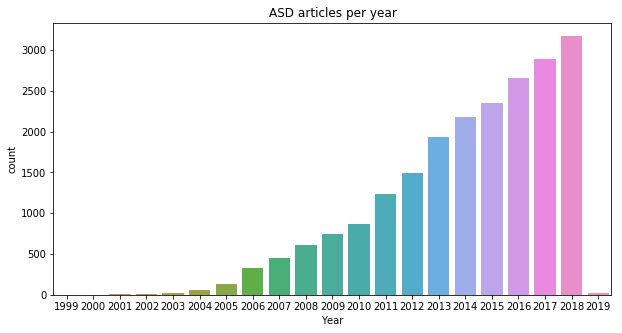

In [13]:
plt.figure(figsize=(10,5))
plt.title('ASD articles per year')
sns.countplot(x='Year', data=df_autism_articles)

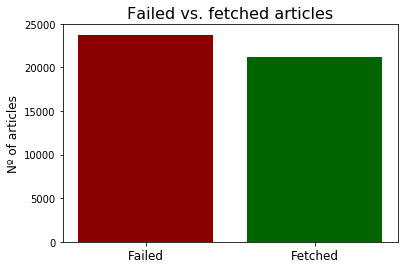

In [14]:
# list_error = file_to_list('listError')
# list_articles_info = df_autism_articles['Abstract']

plt.bar([0,1], [len(list_error), len(list_articles_info)], color=['darkred', 'darkgreen'])
plt.ylabel('Nº of articles', fontsize=12)
plt.xticks([0,1], ['Failed','Fetched'], fontsize=12)
plt.title('Failed vs. fetched articles', fontsize=16)
plt.show()

#### Abstract data preprocessing

In [162]:
# removes all rows/articles with a missing value in any column
df_autism_articles = df_autism_articles.dropna()

# creates a new column in the dataframe for the preprocessed data
preprocessed = pd.Series()
df_autism_articles.insert(loc=1, column='Preprocessed', value=preprocessed)

# replaces with space anything that isn't a lower case or upper case letter
df_autism_articles['Preprocessed'] = df_autism_articles['Abstract'].replace(
    r'[^a-zA-Z]', " ", regex=True)

# replaces multiple spaces with single space
df_autism_articles['Preprocessed'] = df_autism_articles[
    'Preprocessed'].replace(
        r' +', " ", regex=True)

# converts everything to lower case
df_autism_articles['Preprocessed'] = df_autism_articles[
    'Preprocessed'].str.lower()

# removes stop words
stop_words = set(stopwords.words("english"))
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].apply(lambda abstract: 
                                                                              [word for word in str(abstract).split() 
                                                                               if word not in stop_words])

# word stemming
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].apply(lambda abstract: 
                                                                              [stemmer.stem(word) for word in abstract])

# joins the words into one string to be stored in the dataframe
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].str.join(' ')


# saves the dataframe to .csv file
df_autism_articles.to_csv('PreProcessedAbstracts.csv', encoding='utf-8', index=False)

In [163]:
df_autism_articles.head()

,Abstract,Preprocessed,Id,Title,Year
0,To investigate the risk for psychiatric disord...,investig risk psychiatr disord patient newli d...,30609223,Psychiatric Disorders After Attention-Deficit/...,2019
1,A number of studies have documented the benefi...,number studi document benefit neuropsycholog e...,30608513,The Influence of Demographic and Child Charact...,2019
2,Identifying genetic diagnoses for neurologic c...,identifi genet diagnos neurolog condit conside...,30608006,Genetic Testing Practices of Genetic Counselor...,2019
3,Vitamin or mineral supplementation is consider...,vitamin miner supplement consid common use med...,30607900,The Role of Vitamins in Autism Spectrum Disord...,2019
4,GABA<sub>A</sub> receptors are the major inhib...,gaba sub sub receptor major inhibitori neurotr...,30607899,The α5-Containing GABA<sub>A</sub> Receptors-a...,2019


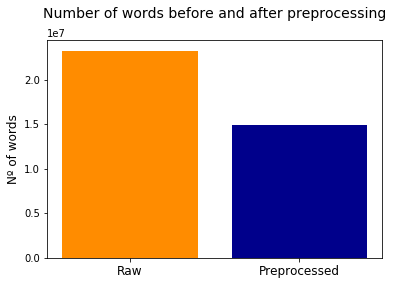

In [164]:
# raw word count
total_word_count = 0
for abstract in df_autism_articles['Abstract']:
    total_word_count = total_word_count + len(abstract)
    
# word count after preprocessing
cleaned_word_count = 0
for abstract in df_autism_articles['Preprocessed']:
    cleaned_word_count = cleaned_word_count + len(abstract)
    
plt.bar([0,1], [total_word_count, cleaned_word_count], color=['darkorange', 'darkblue'])
plt.ylabel('Nº of words', fontsize=12)
plt.xticks([0,1], ['Raw','Preprocessed'], fontsize=12)
plt.title('Number of words before and after preprocessing\n', fontsize=14)
plt.show()

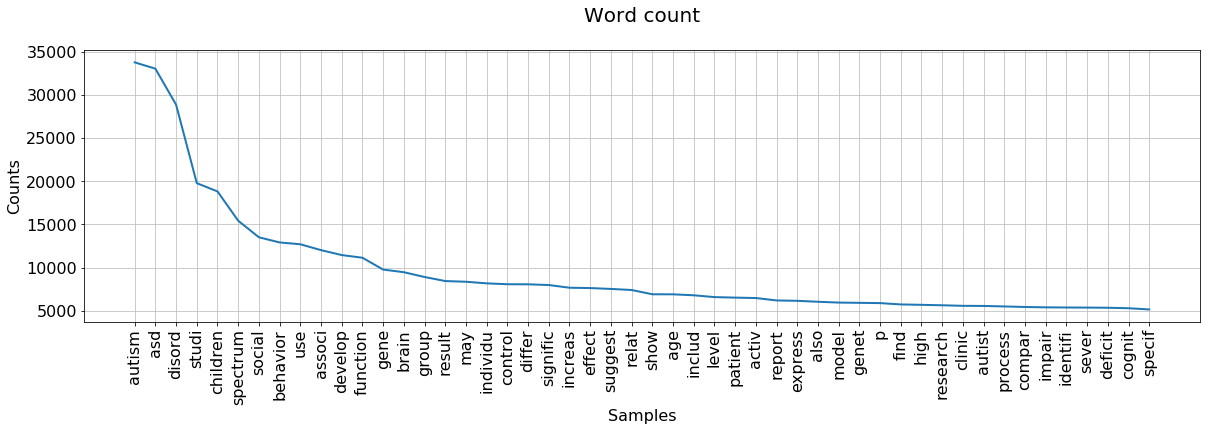

In [165]:
# counts the number of each word
grouped_words = df_autism_articles['Preprocessed'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(grouped_words)
word_freq = nltk.FreqDist(words)

plt.figure(figsize=(20,5))
plt.title('Word count\n', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('', fontsize=16)
plt.ylabel('Counts', fontsize=16)
word_freq.plot(50, cumulative=False)

#### word2vec model

In [168]:
# builds the corpus for the word2vec model
corpus = [abstract_word_list.split(' ') for abstract_word_list in df_autism_articles['Preprocessed']]

# runs the model
# size = number of neurons
# window = maximum distance between the current and predicted word
# min_count =  ignore all words with counts lower than this threshold
# workers = number of threads used to train the model
model = word2vec.Word2Vec(corpus, size=300, window=5, min_count=1000, workers=4)
model.train(corpus, total_examples=len(corpus), epochs=10)
model_name = "model_2_s300_w5_min1000_stemm_train"
model.save(model_name)

print('A total of {} words were used to train the model.'.format(len(model.wv.vocab)))

A total of 444 words were used to train the model.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


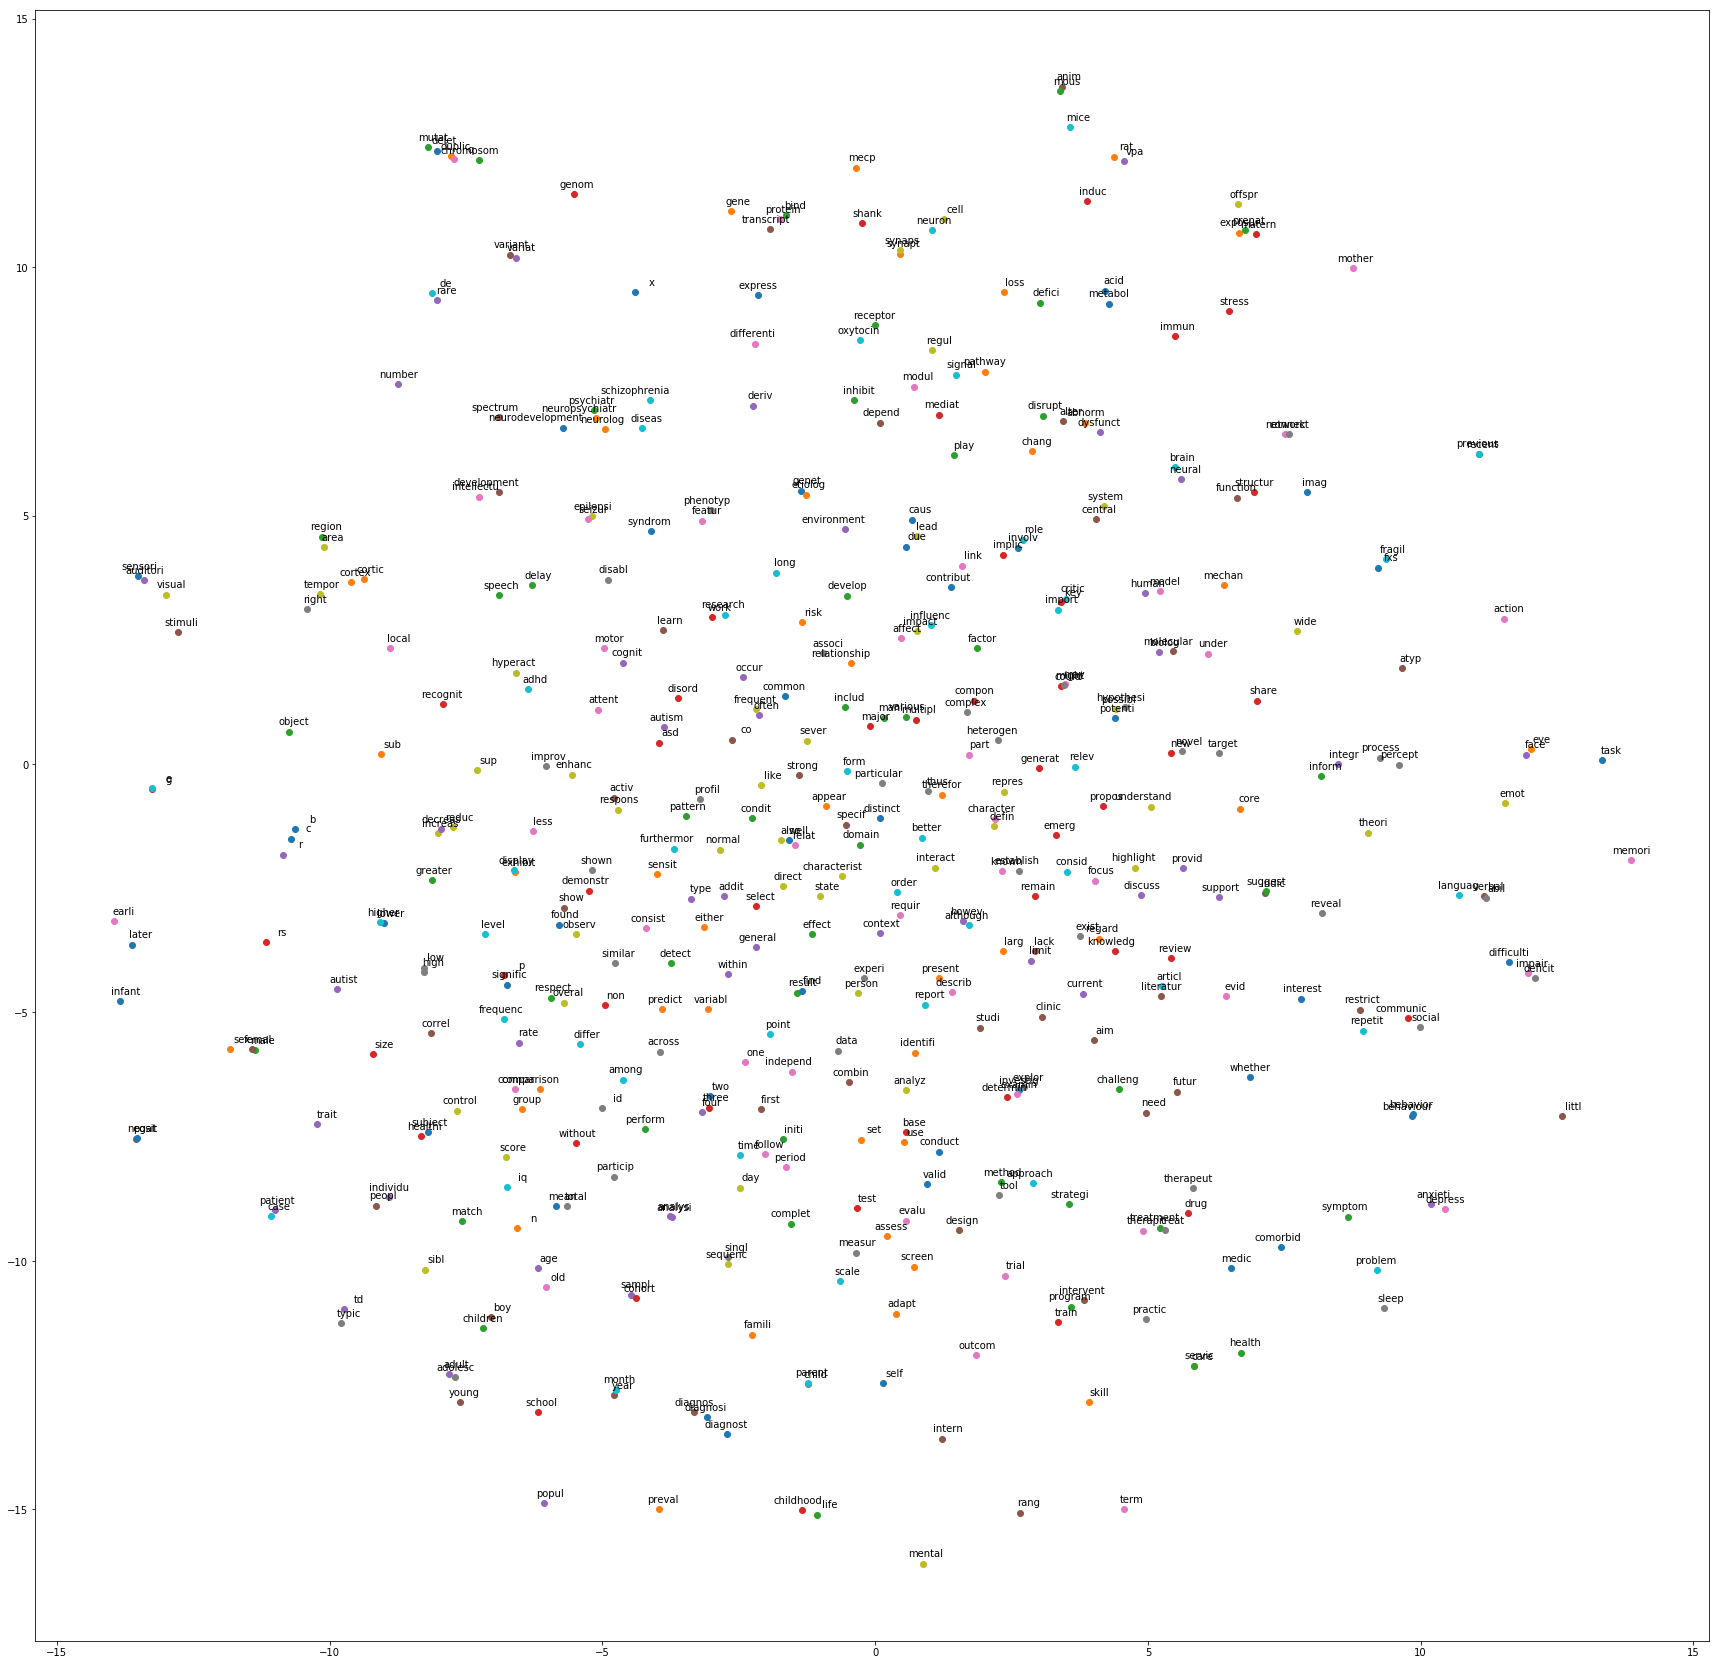

In [172]:
# t-SNE dimension reduction model

labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model[word])
    labels.append(word)

tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2500)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(30, 30)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(20, 5),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.savefig('model_2.png', bbox_inches='tight', dpi=300)
plt.show()

### Improved analysis

#### Expanding the dataset

Dataset size was improved by modifying the get_articles_info() function. The majority of failed fetches were due to an IndexError on the 'Year' path.

In [3]:
# merging the first dataset and the later into one
df_autism_articles_v1 = pd.read_csv('AutismArticlesRaw.csv')
df_autism_articles_v2 = pd.read_csv('AutismArticlesRaw_Error.csv')
df_autism_articles = pd.concat([df_autism_articles_v1, df_autism_articles_v2])

# drops missing values
df_autism_articles.dropna(inplace=True)

# sort by year
df_autism_articles.sort_values('Year', ascending=False, inplace=True)

# update index
index = pd.Series([i for i in range (0, len(df_autism_articles))])
df_autism_articles.index = index

df_autism_articles.to_csv('AutismArticlesRaw_v2.csv', encoding='utf-8', index=False)

df_autism_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37518 entries, 0 to 37517
Data columns (total 4 columns):
Abstract    37518 non-null object
Id          37518 non-null int64
Title       37518 non-null object
Year        37518 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


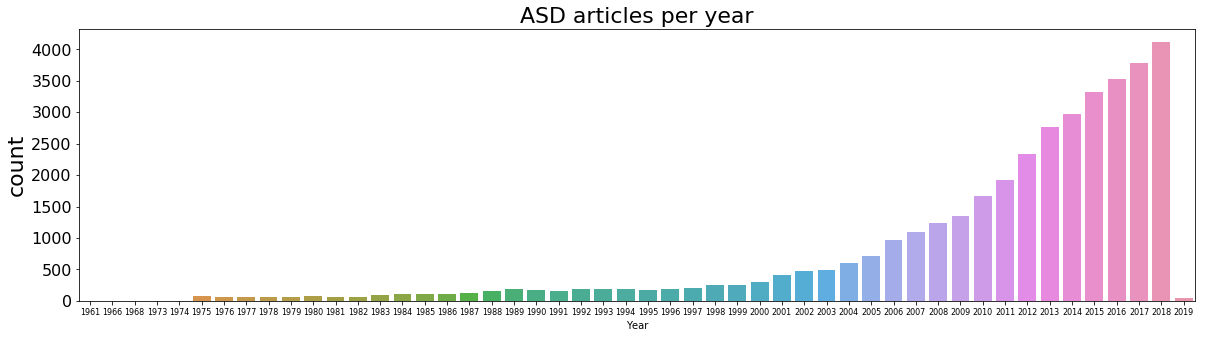

In [15]:
df_autism_articles = pd.read_csv('AutismArticlesRaw_v2.csv')
plt.figure(figsize=(20,5))
plt.xticks(fontsize=8)
plt.yticks(fontsize=16)
plt.ylabel('count', fontsize=22)
plt.title('ASD articles per year', fontsize=22)
sns.countplot(x='Year', data=df_autism_articles)

#### Abstract data preprocessing

In [23]:
# creates a new column in the dataframe for the preprocessed data
preprocessed = pd.Series()
df_autism_articles.insert(loc=1, column='Preprocessed', value=preprocessed)

# replaces with space anything that isn't a lower case or upper case letter
df_autism_articles['Preprocessed'] = df_autism_articles['Abstract'].replace(
    r'[^a-zA-Z]', " ", regex=True)

# replaces multiple spaces with single space
df_autism_articles['Preprocessed'] = df_autism_articles[
    'Preprocessed'].replace(
        r' +', " ", regex=True)

# converts everything to lower case
df_autism_articles['Preprocessed'] = df_autism_articles[
    'Preprocessed'].str.lower()

# removes stop words
stop_words = set(stopwords.words("english"))
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].apply(lambda abstract: 
                                                                              [word for word in str(abstract).split() 
                                                                               if word not in stop_words])

# word stemming
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].apply(lambda abstract: 
                                                                              [stemmer.stem(word) for word in abstract])

# joins the words into one string to be stored in the dataframe
df_autism_articles['Preprocessed'] = df_autism_articles['Preprocessed'].str.join(' ')

# drops missing values
df_autism_articles.dropna(inplace=True)

# saves the dataframe to .csv file
df_autism_articles.to_csv('PreProcessedAbstracts_v2.csv', encoding='utf-8', index=False)

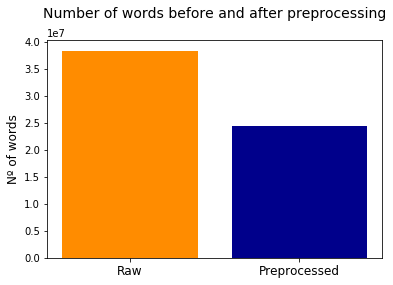

In [6]:
total_word_count = 0
for abstract in df_autism_articles['Abstract']:
    total_word_count = total_word_count + len(abstract)
    
# word count after preprocessing
cleaned_word_count = 0
for abstract in df_autism_articles['Preprocessed']:
    cleaned_word_count = cleaned_word_count + len(abstract)
    
plt.bar([0,1], [total_word_count, cleaned_word_count], color=['darkorange', 'darkblue'])
plt.ylabel('Nº of words', fontsize=12)
plt.xticks([0,1], ['Raw','Preprocessed'], fontsize=12)
plt.title('Number of words before and after preprocessing\n', fontsize=14)
plt.show()

#### word2vec model

In [17]:
df_autism_articles = pd.read_csv('PreProcessedAbstracts_v2.csv')

In [24]:
df_autism_articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37518 entries, 0 to 37517
Data columns (total 5 columns):
Abstract        37518 non-null object
Preprocessed    37518 non-null object
Id              37518 non-null int64
Title           37518 non-null object
Year            37518 non-null int64
dtypes: int64(2), object(3)
memory usage: 1.7+ MB


In [25]:
# builds the corpus for the word2vec model
corpus = [abstract_word_list.split(' ') for abstract_word_list in df_autism_articles['Preprocessed']]

# runs the model
# size = number of neurons
# window = maximum distance between the current and predicted word
# min_count =  ignore all words with counts lower than this threshold
# workers = number of threads used to train the model
model = word2vec.Word2Vec(corpus, size=300, window=5, min_count=1000, workers=4)
model.train(corpus, total_examples=len(corpus), epochs=10)
model_name = "model_2_s300_w5_min1000_stemm_train"
model.save(model_name)

print('A total of {} words were used to train the model.'.format(len(model.wv.vocab)))

A total of 693 words were used to train the model.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


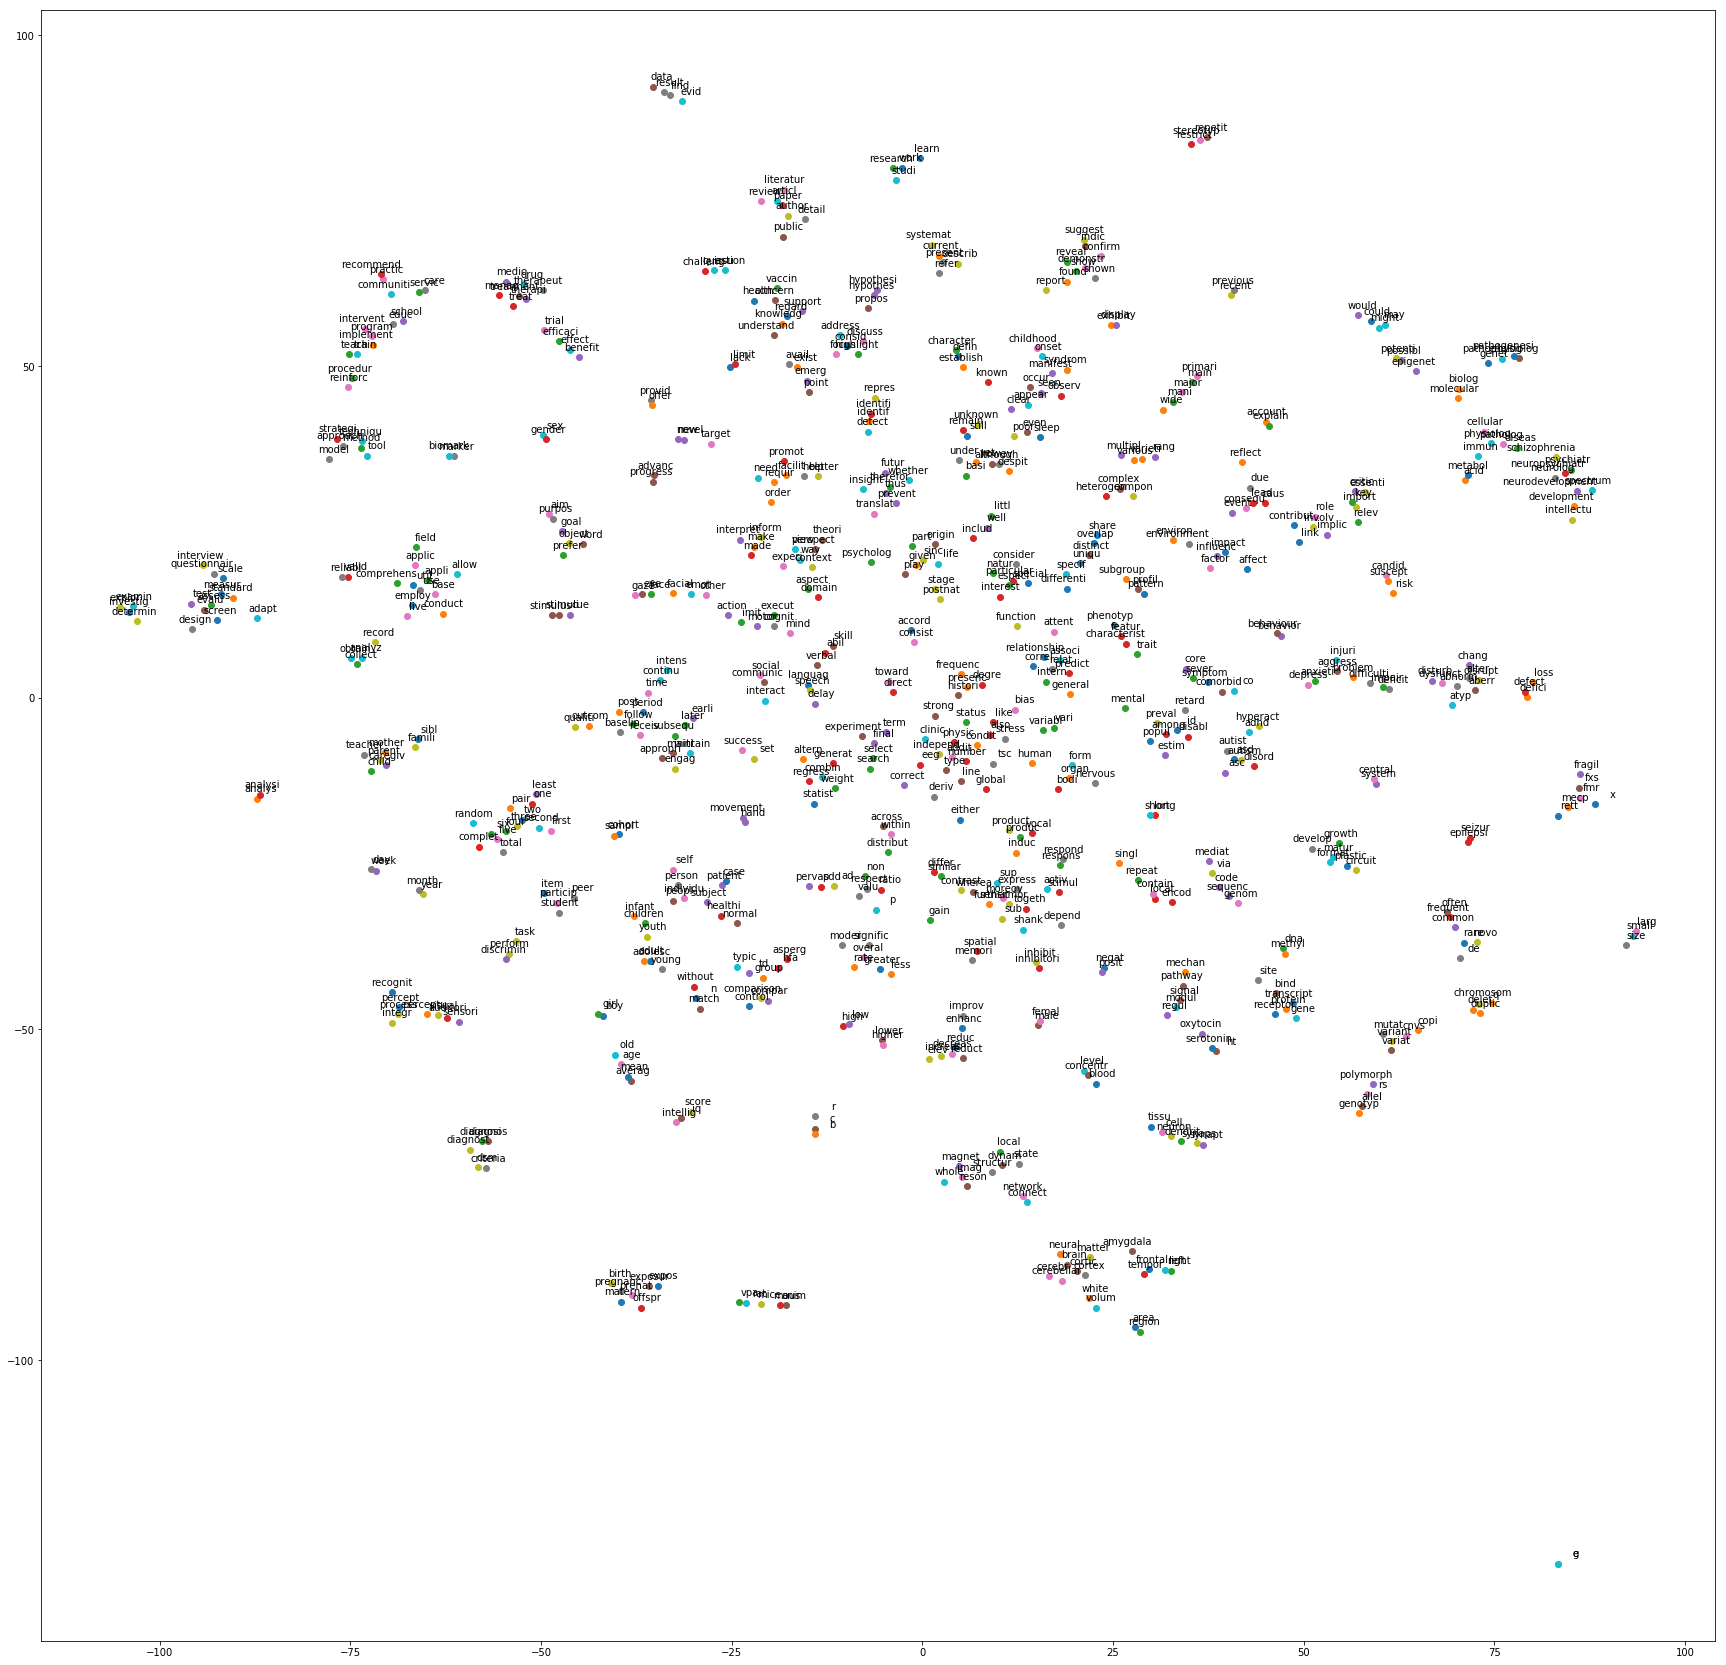

In [26]:
# t-SNE dimension reduction model

labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model[word])
    labels.append(word)

tsne_model = TSNE(perplexity=4, n_components=2, init='pca', n_iter=2500)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(30, 30)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(20, 5),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.savefig('model_3_p4_v2.png', bbox_inches='tight', dpi=300)
plt.show()